(gas-simulation)=
# Gas Simulation

In [3]:
# Fix RC overwriting
%config InlineBackend.rc = {}

import pickle
from pathlib import Path

import awkward as ak
import numpy as np
from hist import Hist
from matplotlib import pyplot as plt
from mplhep.styles import ROOT
from scipy.stats import linregress, norm
from texat.utils.awkward.convert import from_hdf5

plt.style.use(ROOT)
plt.rc("figure", figsize=(10, 5), dpi=120)
data_path = Path("data")

## Drift Velocity

The transformation from energy-time space of the GET waveforms to the energy-position space of the reconstructed charge clusters requires knowledge of the intrinsic drift velocity of the MicroMeGaS detector. The drift velocity is a function of the gas parameters (pressure, temperature, etc.) and the applied electric field within the drift chamber. The parameters for the experimental run described in this chapter are recorded in {numref}`drift-parameters`

:::{list-table} The gas and field parameters that govern charge transport within the active chamber
:name: drift-parameters
:header-rows: 1

- - Name
  - Value
- - Pressure
  - 405 Torr
- - Temperature
  - 290 K
- - Composition
  - 96% <sup>4</sup>He, 4% CO2
- - Drift Field
  - 53.85 V/cm
:::


The phenomenon of electron diffusion within a gas is described by the Boltzmann transport equation (BTE), which models the phase-space evolution of a system in the absence of significant ionization. Given the distribution function {math}`f(\vb{r}, \vb{v}, t)` describing the number density of electrons at the locus {math}`(\vb{r}, \vb{v}, t)` in phase space, the BTE may be expressed as  
:::{math}
:label: boltzmann-transport-equation

\pdv{f}{t} + \pdv{f}{\vb{r}}\cdot\dot{\vb{r}} +
             \pdv{f}{\vb{v}}\cdot\dot{\vb{v}} 
           = \pqty{\pdv{f}{t}}_{\text{coll}}\,,
:::
where {math}`\pqty{\pdv{f}{t}}_{\text{coll}}` represents the rate of change due to collision processes. 

:::{admonition} To Do
:class: margin


Show how this follows for web
:::

:::{admonition} To Do
:class: margin


Note effect of CO2 and lateral and transverse drift velocities: https://agenda.infn.it/event/4542/contributions/53648/attachments/38405/45162/Veenhof-II.pdf
https://indico.cern.ch/event/122157/attachments/69728/99908/R_Veenhof.pdf
:::

{eq}`boltzmann-transport-equation` is nontrivial to solve. Under the assumption of a constant uniform electric field, the distribution function may be reparametrised in terms of the electron energy $\epsilon$ and angle to the field $\theta$ such that $f$ may be written as an expansion in the Legendre polynomials.{cite:ps}`palladino_application_1974` This simplification yields a set of coupled differential equations, which can be solved with numerical methods. An experimental code that numerically solves the BTE, Magboltz, is described in {cite:ps}`palladino_application_1974`. Recent versions of the Magboltz program solve the problem of electron transport with Monte Carlo techniques, which yields solutions whose accuracy depends solely upon computation time.{cite:ps}`biagi_monte_1999`

% note that assumptions change for GEM https://aip.scitation.org/doi/10.1063/5.0009286

A Magboltz simulation was performed to compute the mean drift velocity within the TPC for the parameters given in {numref}`drift-parameters`. The drift velocity was found to be 5.302&nbsp;µm/ns

## Cluster Resolution

Using a microscopic Monte Carlo model, the spread of the drift electrons can be determined as a function of displacement. The Garfield++ detector simulation toolkit includes a microscopic tracking component that consumes the per-scattering-process collision rates {math}`\tau_i^{-1}(\epsilon)` computed by Magboltz in order to evolve single electrons through time. An aggregate of these single-particle walks can be used to determine the distribution of the drift time and widths in the transverse and drift axes. {numref}`x-distribution-garfield` shows the transverse position resolution of electrons produced at a drift height of 5.90&nbsp;cm.

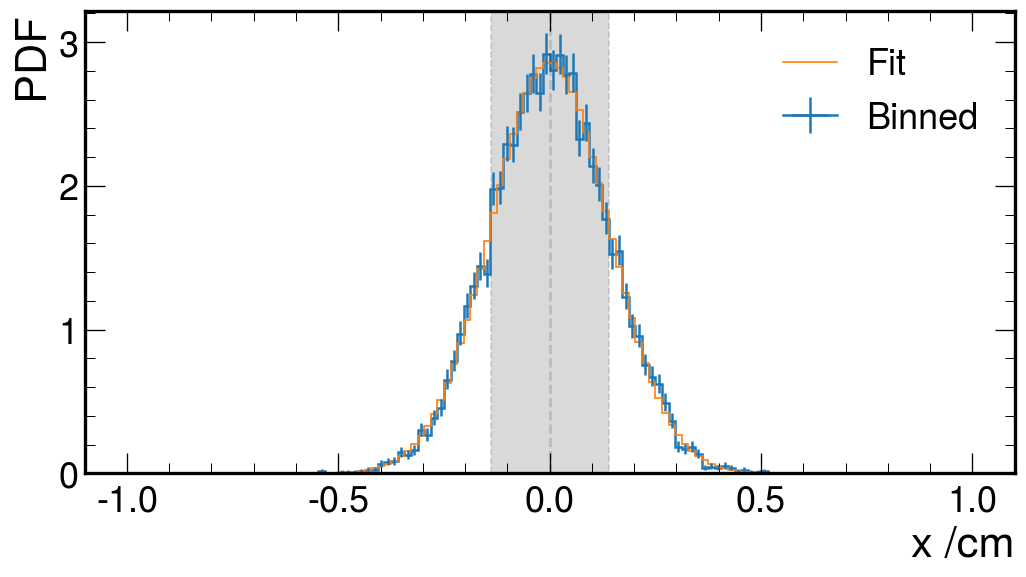

In [35]:
avalanche = ak.from_json(data_path / "avalanche.json")
# Sort by height
avalanche = avalanche[np.argsort(avalanche.y)]
# Final entry is bogus
avalanche = avalanche[:-1]

hist = Hist.new.Reg(128, -1, 1).Int64().fill(avalanche[-1].endpoints.x)
mu, sigma = norm.fit(avalanche[-1].endpoints.x)

plt.axvline(0, linestyle="--", color=plt.rcParams['axes.edgecolor'], alpha=0.15)
plt.axvspan(-sigma, sigma, linestyle="--", color=plt.rcParams['axes.edgecolor'], alpha=0.15)

hist.plot(density=True, label="Binned")
plt.stairs(
    norm.pdf(hist.axes[0].centers, mu, sigma),
    hist.axes[0].edges,
    color="C1",
    label="Fit",
)
plt.xlabel("x /cm")
plt.ylabel("PDF")
plt.legend();

A regression of the transverse spread against the drift height shows a linear correlation (see {numref}`x-distribution-regression`).

:::{admonition} To Do
:class: margin


Justify linear regression
:::

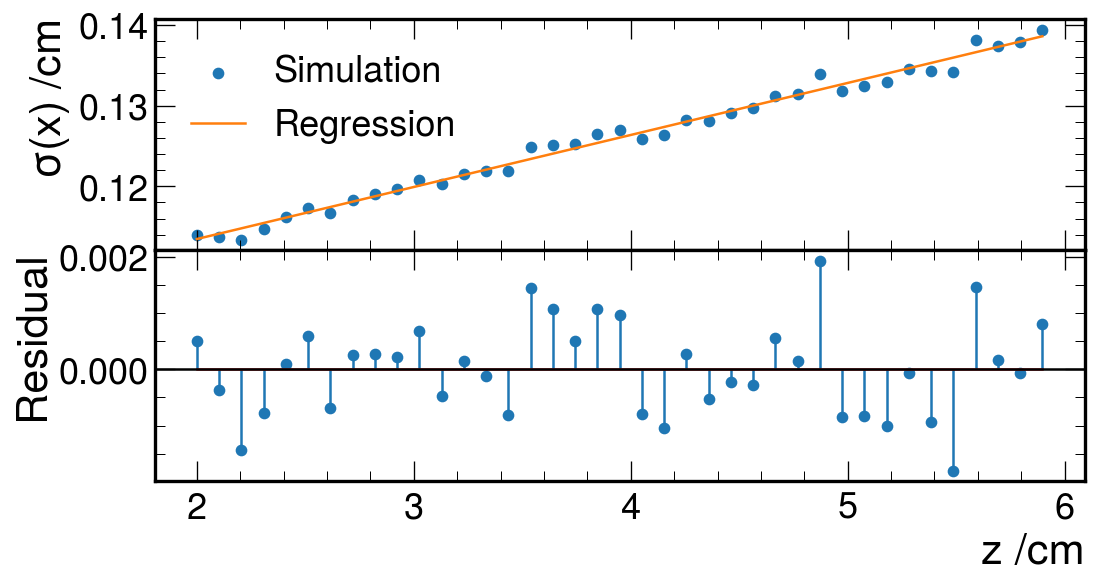

In [38]:
x_std = np.std(avalanche.endpoints.x, axis=-1)
x_fit = linregress(avalanche.y, x_std)

fig, ax = plt.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0})
handles = [
    ax[0].scatter(avalanche.y, x_std, label="Simulation"),
    *ax[0].plot(
        avalanche.y,
        x_fit.intercept + x_fit.slope * avalanche.y,
        label="Regression",
        color="C1",
    ),
]
ax[0].set_ylabel("$\sigma(x)$ /cm")
ax[1].stem(
    avalanche.y,
    x_std - (x_fit.intercept + x_fit.slope * avalanche.y),
)
ax[1].axhline(0, color="black", linestyle="-")
ax[1].set_ylabel("Residual")
plt.xlabel("z /cm")
ax[0].legend(handles=handles, loc="upper left");